# Preface

This version focuses on the logistic regression model. For a comprehensive overview of all models and detailed analyses, refer to versions 1-3

80.8 https://www.kaggle.com/code/escape2free/titanic-eda-lr-dt-rf-gbt

# Step 1: Import Dependencies

In [23]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np
import re

# Step 2: Load Dataset

In [24]:
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Step 3: Data Preprocessing

- Strategies for handling missing values
    - As Age approximates a normal distribution, assign the mean value to Age based on the titles in the Name column.
    - Cabin has a missing value percentage of 77%, which is too much. Delete that column.
    - There are 2 missing values in Embarked. Fill them with the most common value 'S' based on its percentage.
- Text Data Processing
    - For the "Name" column, perform feature extraction using TF-IDF (Term Frequency-Inverse Document Frequency).
    - Encode features for "Sex," "Embarked," and "TicketPref" using one-hot encoding.

In [25]:
def name_title(x):
    return x.split('.')[0].split(' ')[-1]

def remove_noise(x):
    return re.sub(r'[".,()]+', '', x)

def ticket_pref(x):
    if len(x.split(' ')) == 1:
        return 'nan'
    else:
        x = ".".join(x.split(' ')[:-1])
        return re.sub(r'[./]+', '', x).lower()

def ticket_ID(x):
    x = x.split(' ')[-1]
    return int(x) if x.isdigit() else 0

In [26]:
# Data Preprocessing
def preprocessing(df):
    df = df.copy()
    
    # Missing Data Handling
    df['NameTitle'] = df['Name'].apply(name_title)
    
    # Fill in missing values
    df['Age'].fillna(df['NameTitle'].map(df.groupby('NameTitle')['Age'].mean()), inplace=True)
    df['Embarked'].fillna('S', inplace=True)

    # Remove Noise
    df['Name'] = df['Name'].apply(remove_noise)

    # Standardize Text Content
    df['TicketPref'] = df['Ticket'].apply(ticket_pref)
    df['TicketID'] = df['Ticket'].apply(ticket_ID)

    return df

train_df = preprocessing(df)
y = train_df['Survived']
X = train_df.drop(['PassengerId', 'Survived', 'Ticket', 'NameTitle', 'Cabin'], axis=1)
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,TicketPref,TicketID
0,3,Braund Mr Owen Harris,male,22.0,1,0,7.2500,S,a5,21171
1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,71.2833,C,pc,17599
2,3,Heikkinen Miss Laina,female,26.0,0,0,7.9250,S,stono2,3101282
3,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,53.1000,S,nan,113803
4,3,Allen Mr William Henry,male,35.0,0,0,8.0500,S,nan,373450


In [27]:
# Data Transformation
# Extracting columns with numerical features
numeric_columns = selector(dtype_include='number')

# Define each step in the pipeline
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Use ColumnTransformer to specify the processing method for each column
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'Name'),
        ('categorical', categorical_transformer, ['Sex', 'Embarked', 'TicketPref']),
        ('numeric', numeric_transformer, numeric_columns)
    ])

# Create a complete pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Use a pipeline to process data
X_processed = pipeline.fit_transform(X)

# Step 4: Data Splitting

In [28]:
# Splitting the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=0)

# Step 5: Modeling (Logistic Regression)

In [29]:
# Create Logistic Regression 
lr = LogisticRegression()

# Define parameter grid
param_grid = {
    'C': np.logspace(-3, 3, 7),
    'max_iter': list(range(5, 50, 1)),
}

# Set the scoring metric
scorer = make_scorer(accuracy_score)

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring=scorer,
    cv=5 # Using 5-fold cross-validation
)

# Run grid search
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the model on the test set
lr_model = grid_search.best_estimator_
y_pred = lr_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Best Parameters:  {'C': 10.0, 'max_iter': 38}
Accuracy: 0.8379888268156425
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       110
           1       0.80      0.77      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



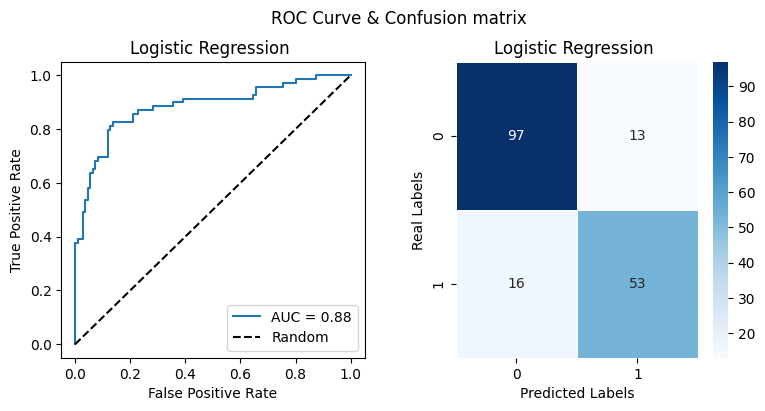

In [30]:
# Predicted probability scores
y_scores = lr_model.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'wspace': 0.3, 'top':0.85})
fig.suptitle('ROC Curve & Confusion matrix')

# Calculate the values of the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
# Calculate AUC（Area Under the Curve）
auc = roc_auc_score(y_test, y_scores)

plt.sca(axes[0])
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ')
plt.legend()

plt.sca(axes[1])
y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', linewidths=.5)
plt.title('Logistic Regression ')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')
plt.show()

# Step 6: Predicting

In [31]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [32]:
def preprocess_data(df):
    df = df.copy()

    # Missing Data Handling
    df['NameTitle'] = df['Name'].apply(name_title)

    # Fill in missing values
    df['Age'].fillna(train_df['NameTitle'].map(train_df.groupby('NameTitle')['Age'].mean()), inplace=True)
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)

    # Remove Noise
    df['Name'] = df['Name'].apply(remove_noise)

    # Standardize Text Content
    df['TicketPref'] = df['Ticket'].apply(ticket_pref)
    df['TicketID'] = df['Ticket'].apply(ticket_ID)
    
    df = df.drop(['PassengerId', 'Ticket', 'NameTitle', 'Cabin'], axis=1)
    return df

# Data preprocessing
test = preprocess_data(test_data)
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,TicketPref,TicketID
0,3,Kelly Mr James,male,34.5,0,0,7.8292,Q,nan,330911
1,3,Wilkes Mrs James Ellen Needs,female,47.0,1,0,7.0000,S,nan,363272
2,2,Myles Mr Thomas Francis,male,62.0,0,0,9.6875,Q,nan,240276
3,3,Wirz Mr Albert,male,27.0,0,0,8.6625,S,nan,315154
4,3,Hirvonen Mrs Alexander Helga E Lindqvist,female,22.0,1,1,12.2875,S,nan,3101298


In [33]:
# Data Transformation
X_test_processed = pipeline.transform(test)

# Predicting
val = lr_model.predict(X_test_processed)
sub = pd.read_csv("gender_submission.csv")
sub['Survived'] = val
sub.to_csv('submission_csv.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
